In [1]:
import os
import json
import gzip
import itertools
from itertools import chain
import pandas as pd
import numpy as np
import networkx as nx

import scipy.sparse as spsparse
import scipy.stats as spstats

from statsmodels.stats.multitest import multipletests as holm
import statsmodels.api as sm

from linearmodels import PanelOLS

import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import matplotlib.transforms as mtransforms
import seaborn as sns

from vizutils import pvalue2stars, table_row, make_multinomial_latex_table

import pyscisci.all as pyscisci

# Calculate the Citation Preference 

In [ ]:
# calculate the AUC for each country pair


# read in the country citation data
for dataset in ["oa_countrycites", "oa_countrycites_noself", "oa_countrycites_nosameorg"]:

    countrycites = pd.read_csv(os.path.join(path2countrydata, dataset + ".csv.gz"))

    country_auc_df = []
    def country_auc(citedf):
        for cited_c in citedf['Country'].unique():
            x = citedf[citedf['Country'] == cited_c]['CountryCitations'].values
            y = citedf[citedf['Country'] != cited_c]['CountryCitations'].values
            auc, delongcov = pyscisci.fast_delong(x, y)
            cname, y = citedf.name
            country_auc_df.append([cname, y, cited_c, auc, delongcov, x.shape[0]])

    countrycites.groupby(['CitingCountry', 'CitedYear'])[['Country', 'CountryCitations']].apply(country_auc)
    country_auc_df = pd.DataFrame(country_auc_df, columns=['CitingCountry', 'CitedYear', 'CitedCountry', 'AUC', 'Cov', 'N'])

    country_auc_df.to_csv(os.path.join(path2countrydata, dataset + '_auc.csv.gz'), compression='gzip', 
                                       index=False, header=True, mode='w')

    print(dataset)

In [ ]:
# and the journal bootstrap AUC

def country_journal_auc_year(citedf, cname, y):
    
    baseline_df = citedf.drop_duplicates(subset=['CitedPublicationId']).reset_index(drop = True)
    
    for cited_c in citedf['Country'].unique():
        
        focus_c_df = citedf[citedf['Country'] == cited_c]
        
        xs = focus_c_df['CountryCitations'].values
        
        if xs.shape[0] >=50:
            
            baseline_df['sample_count'] = np.nan
            journal_counts = focus_c_df['CitedJournalId'].value_counts()
            baseline_df['sample_count'] = baseline_df['CitedJournalId'].map(journal_counts)
            sampled_df = baseline_df.dropna(subset=['sample_count'])
            
            for isample in range(nsamples):
                sampled_df = sampled_df.sample(frac=1)
                sampled_df['cum_count'] = sampled_df.groupby('CitedJournalId', sort=False).cumcount()
        
                ys = sampled_df[sampled_df['cum_count'] < sampled_df['sample_count']]['CountryCitations'].values

                auc = pyscisci.fast_auc(xs,ys)
                
                country_auc_df_year.append([cname, y, cited_c, auc, xs.shape[0], isample])


nsamples=100
country_auc_df_sample = []
for focus_year in range(1990,2018):

    countrycites_year = countrycites[countrycites['CitedYear'] == focus_year]

    country_auc_df_year = []

    for citing_c in countrycites_year['CitingCountry'].unique():
        country_auc_year(countrycites_year[countrycites_year['CitingCountry'] == citing_c], cname=citing_c, y=focus_year)
        print(citing_c)

    #aucdf = pd.DataFrame(country_auc_df_year, columns=['CitingCountry', 'CitedYear', 'CitedCountry', 'AUC', 'Cov', 'N', 'isample'])
    aucdf = pd.DataFrame(country_auc_df_year, columns=['CitingCountry', 'CitedYear', 'CitedCountry', 'AUC',  'N', 'isample'])
    country_auc_df_sample.append(aucdf)

    aucdf.to_csv(os.path.join(path2countrydata, 'nationalcitation_bootstrap_u100_{}.csv.gz'.format(focus_year), 
                 compression='gzip', index=False, header=True)

country_auc_df_sample = pd.concat(country_auc_df_sample)
country_auc_df = country_auc_df_sample.groupby(['CitingCountry', 'CitedYear', 'CitedCountry', 'N'], as_index=False)['AUC'].var()
country_auc_df.rename(columns={'AUC':'Cov'},inplace=True)
country_auc_df = country_auc_df.merge(country_auc_df_sample.groupby(['CitingCountry', 'CitedYear', 'CitedCountry', 'N'], as_index=False)['AUC'].mean(),
how='left', on = ['CitingCountry', 'CitedYear', 'CitedCountry'])

country_auc_df.to_csv(os.path.join(path2countrydata, 'nationalcitation_bootstrap_u100.csv.gz', 
                 compression='gzip', index=False, header=True)

 # Analysis of the International Recognition Network

In [2]:
# lets focus on the citation without the same organization and self citations

country_auc_df = pd.read_csv(os.path.join('data', 'oa_countrycites_nosameorg_auc.csv.gz'))

country_auc_df = country_auc_df[country_auc_df['N']>=50]

country_auc_df['Zscore'] = (country_auc_df['AUC'] - 0.5)/np.sqrt(country_auc_df['Cov'])
country_auc_df['pvalue'] = spstats.norm.sf(np.abs(country_auc_df['Zscore'].values))

def reject_holm(pvalues):
    reject, pvalues, _, _ = holm(pvalues, alpha=0.01, method='hs', is_sorted=False, returnsorted=False)
    return reject
country_auc_df['Significant'] = country_auc_df.groupby('CitedYear')['pvalue'].transform(reject_holm)

net_auc = country_auc_df[country_auc_df['CitingCountry'] != country_auc_df['CitedCountry']].sort_values(by=['CitedYear', 'CitedCountry']).reset_index(drop=True)
net_auc = net_auc[net_auc['Significant']]
self_auc = country_auc_df[country_auc_df['CitingCountry'] == country_auc_df['CitedCountry']].sort_values(by=['CitedYear', 'CitedCountry']).reset_index(drop=True)
self_auc = self_auc[self_auc['Significant']]

syear, eyear = 1990, 2017
net_auc = net_auc[net_auc['CitedYear'] >= syear]
net_auc = net_auc[net_auc['CitedYear'] <= eyear]

comm2country = {0:['AE', 'BD', 'CN', 'CY', 'DZ', 'EG', 'ID', 'IN', 'IQ', 'IR', 'JO', 'KH', 'KR', 'KW', 'MA', 'MY', 'OM', 'PK', 'QA', 'SA', 'SG', 'TH', 'TN', 'TR', 'TW', 'VN'],
1:['AR', 'BN', 'BO', 'BR', 'BW', 'BY', 'CL', 'CM', 'CO', 'CR', 'GE', 'HK', 'HR', 'LU', 'MZ', 'NC', 'PA', 'PE', 'RU', 'SJ', 'ST', 'UY', 'VE'],
2:['AT', 'BE', 'CA', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GR', 'HU', 'IE', 'IL', 'IS', 'IT', 'JP', 'MX', 'NL', 'NO', 'NP', 'NZ', 'PH', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK'],
3:['AU', 'CH', 'GB', 'US'],
4:['BH', 'ET', 'GH', 'KE', 'MW', 'NG', 'TZ', 'UG', 'ZA', 'ZM', 'ZW']}

country2comm = {c:ci for ci,clist in comm2country.items() for c in clist}
poscountrylist = sorted(list(country2comm.keys()))

connected_countries = np.sort(np.unique(net_auc[net_auc['Zscore'] > 0][['CitingCountry', 'CitedCountry']].values.flatten()))

In [3]:
syear, eyear = 1990, 2017
net_auc = net_auc[net_auc['CitedYear'] >= syear]
net_auc = net_auc[net_auc['CitedYear'] <= eyear]
cumulative_net = net_auc.sort_values('CitedYear').drop_duplicates(subset=['CitingCountry', 'CitedCountry'], keep='last')

cumulative_net['SourceCommunity'] = cumulative_net['CitingCountry'].map(country2comm)
cumulative_net['TargetCommunity'] = cumulative_net['CitedCountry'].map(country2comm)
cumulative_net['InterCommunity'] = cumulative_net['SourceCommunity'] != cumulative_net['TargetCommunity']

print(cumulative_net.shape, "edges")
cum_connected_countries = np.sort(np.unique(cumulative_net[['CitingCountry', 'CitedCountry']].values.flatten()))
print(cum_connected_countries.shape, "countries")
pcumnet = cumulative_net[cumulative_net['Zscore'] > 0]
print(pcumnet.shape, "positive edges")
print(pcumnet['CitedCountry'].value_counts())
ncumnet = cumulative_net[cumulative_net['Zscore'] < 0]
print(ncumnet.shape, "negative edges")
print(ncumnet['CitedCountry'].value_counts())

(2007, 12) edges
(147,) countries
(536, 12) positive edges
CitedCountry
CH    36
GB    31
NL    22
DE    22
BE    20
      ..
RU     1
CR     1
HR     1
PE     1
MA     1
Name: count, Length: 81, dtype: int64
(1471, 12) negative edges
CitedCountry
CN    86
JP    63
IR    48
BR    45
TR    45
      ..
CG     1
TJ     1
PH     1
HK     1
GD     1
Name: count, Length: 126, dtype: int64


## relationship between Degree and Productivity

In [16]:
countryprod = pd.read_csv('data/oa_country_productivity.csv')
syear = 1990
eyear = 2017

countryprod = countryprod[countryprod['Year'] >= syear]
countryprod = countryprod[countryprod['Year'] <= eyear].reset_index(drop=True)
print(countryprod.shape)

(5869, 5)


In [17]:
deg_table = cumulative_net[cumulative_net['Zscore'] > 0].groupby('CitedCountry', as_index=False)['CitingCountry'].nunique()
deg_table = deg_table.rename(columns={'CitedCountry':'Country', 'CitingCountry':'Pos. In Deg'})

deg_table2 = cumulative_net[cumulative_net['Zscore'] > 0].groupby('CitingCountry', as_index=False)['CitedCountry'].nunique()
deg_table2 = deg_table2.rename(columns={'CitingCountry':'Country', 'CitedCountry':'Pos. Out Deg'})
deg_table = deg_table.merge(deg_table2, how='outer')

deg_table3 = cumulative_net[cumulative_net['Zscore'] < 0].groupby('CitedCountry', as_index=False)['CitingCountry'].nunique()
deg_table3 = deg_table3.rename(columns={'CitedCountry':'Country', 'CitingCountry':'Neg. In Deg'})
deg_table = deg_table.merge(deg_table3, how='outer')

deg_table4 = cumulative_net[cumulative_net['Zscore'] < 0].groupby('CitingCountry', as_index=False)['CitedCountry'].nunique()
deg_table4 = deg_table4.rename(columns={'CitingCountry':'Country', 'CitedCountry':'Neg. Out Deg'})
deg_table = deg_table.merge(deg_table4, how='outer')

deg_table = deg_table.merge(countryprod[countryprod['Year']==2017][['Country', 'NumPub']], how='left')
deg_table = deg_table.fillna(0)

deg_table

,Country,Pos. In Deg,Pos. Out Deg,Neg. In Deg,Neg. Out Deg,NumPub
0,AE,4.0,2.0,9.0,3.0,4997
1,AF,0.0,0.0,0.0,1.0,122
2,AG,0.0,0.0,0.0,1.0,204
3,AL,0.0,0.0,2.0,1.0,572
4,AM,0.0,0.0,2.0,2.0,1055
...,...,...,...,...,...,...
142,XK,0.0,0.0,2.0,2.0,631
143,YE,0.0,0.0,1.0,0.0,403
144,ZA,11.0,14.0,11.0,16.0,23661
145,ZM,1.0,1.0,2.0,4.0,702


A 7.301527208769858e-08
B 5.5096794626183193e-17
C 6.037579349008931e-14
D 1.5724814676183918e-44


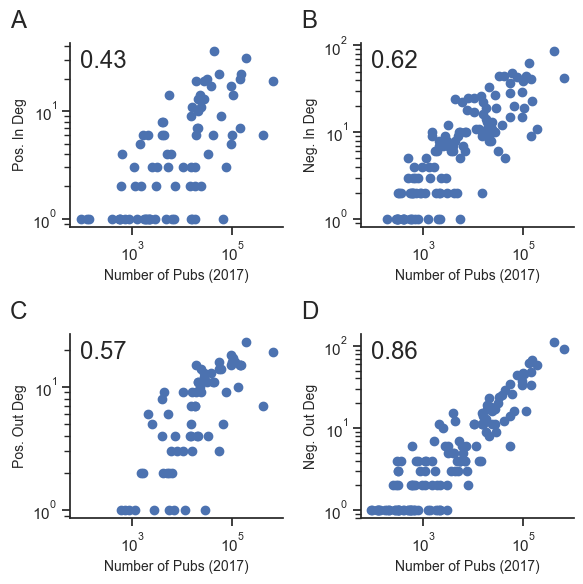

In [18]:
fig, ax = plt.subplots(2,2,figsize=(6,6))

fig_list = [('A', 'Pos. In Deg'), ('B', 'Neg. In Deg'), ('C', 'Pos. Out Deg'), ('D', 'Neg. Out Deg')]
for i, (lbl, yvar) in enumerate(fig_list):
    lax = ax[i//2,i%2]
    lax.scatter(deg_table['NumPub'], deg_table[yvar])
    lax.set_xscale('log')
    lax.set_yscale('log')
    lax.set_ylabel(yvar, fontsize=10)
    lax.set_xlabel('Number of Pubs (2017)', fontsize=10)

    corr = spstats.pearsonr(deg_table['NumPub'], deg_table[yvar])
    #corr = spstats.spearmanr(deg_table['NumPub'], deg_table[yvar])
    corr_str = str(np.round(corr.statistic,2))
    print(lbl, corr.pvalue)
    trans = mtransforms.ScaledTranslation(0.1, -0.3, fig.dpi_scale_trans)
    lax.text(0.0, 1.0, corr_str, transform=lax.transAxes + trans,
                   fontsize='x-large', va='bottom')

    trans = mtransforms.ScaledTranslation(-0.6, 7/72, fig.dpi_scale_trans)
    lax.text(0.0, 1.0, lbl, transform=lax.transAxes + trans,
                   fontsize='x-large', va='bottom')

plt.tight_layout()

plt.show()

D 1.019899490895749e-26
E 5.216950854231589e-23
F 3.0042940684550073e-07
A 0.091939989100021
B 0.0342705024511236
C 0.376347547607824


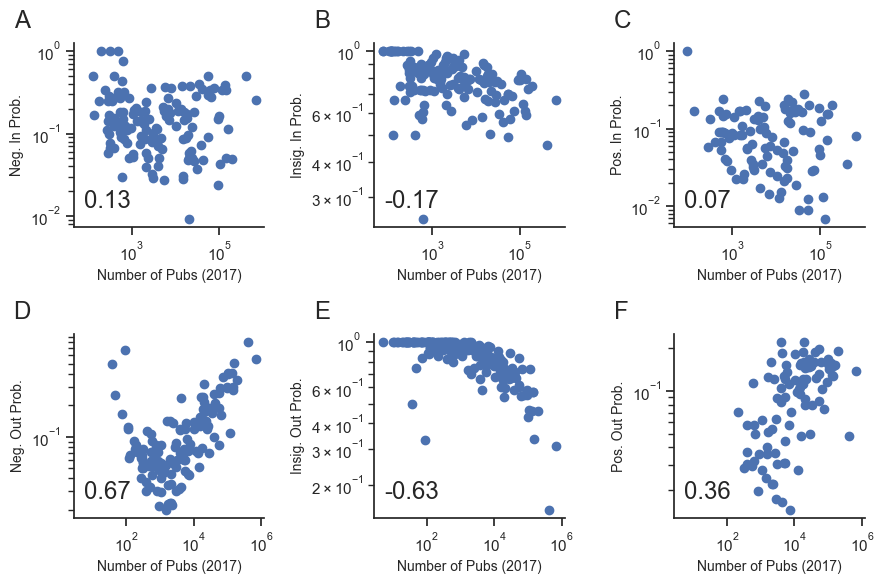

In [20]:
country_auc_df = pd.read_csv(os.path.join('data', 'oa_countrycites_nosameorg_auc.csv.gz'))

country_auc_df['Zscore'] = (country_auc_df['AUC'] - 0.5)/np.sqrt(country_auc_df['Cov'])

n2017 = country_auc_df[country_auc_df['CitedYear'] == 2017]
n2017 = n2017[n2017['N'] >= 50].reset_index(drop=True)
n2017['Sign'] = 0
n2017.loc[n2017['Zscore']<-3, 'Sign'] = -1
n2017.loc[n2017['Zscore']>3, 'Sign'] = 1


prob_edge = []
for c in n2017['CitingCountry'].unique():
    csub = n2017[n2017['CitingCountry']==c]['Sign'].value_counts().to_dict()
    prob_edge.append([c] + [csub.get(v, 0) for v in [-1, 0, 1]])

prob_edge = pd.DataFrame(prob_edge, columns= ['Country', 'Neg. Out Prob.', 'Insig. Out Prob.', 'Pos. Out Prob.']) 
prob_edge['Total'] = prob_edge[['Neg. Out Prob.', 'Insig. Out Prob.', 'Pos. Out Prob.']].sum(axis=1)
for c in ['Neg. Out Prob.', 'Insig. Out Prob.', 'Pos. Out Prob.']:
    prob_edge[c] = prob_edge[c]/prob_edge['Total']

prob_edge = prob_edge.merge(countryprod[countryprod['Year']==2017][['Country', 'NumPub']], how='left')
prob_edge = prob_edge.fillna(0)

fig, ax = plt.subplots(2,3,figsize=(9,6))

fig_list = [('D', 'Neg. Out Prob.'), ('E', 'Insig. Out Prob.'), ('F', 'Pos. Out Prob.')]
for i, (lbl, yvar) in enumerate(fig_list):
    lax = ax[1,i]
    lax.scatter(prob_edge['NumPub'], prob_edge[yvar])
    lax.set_xscale('log')
    lax.set_yscale('log')
    lax.set_ylabel(yvar, fontsize=10)
    lax.set_xlabel('Number of Pubs (2017)', fontsize=10)

    corr = spstats.pearsonr(prob_edge['NumPub'], prob_edge[yvar])
    print(lbl, corr.pvalue)
    #corr = spstats.spearmanr(deg_table['NumPub'], deg_table[yvar])
    corr_str = str(np.round(corr.statistic,2))
    
    trans = mtransforms.ScaledTranslation(0.1, -1.7, fig.dpi_scale_trans)
    lax.text(0.0, 1.0, corr_str, transform=lax.transAxes + trans,
                   fontsize='x-large', va='bottom')

    trans = mtransforms.ScaledTranslation(-0.6, 7/72, fig.dpi_scale_trans)
    lax.text(0.0, 1.0, lbl, transform=lax.transAxes + trans,
                   fontsize='x-large', va='bottom')


prob_edge = []
for c in n2017['CitedCountry'].unique():
    csub = n2017[n2017['CitedCountry']==c]['Sign'].value_counts().to_dict()
    prob_edge.append([c] + [csub.get(v, 0) for v in [-1, 0, 1]])

prob_edge = pd.DataFrame(prob_edge, columns= ['Country', 'Neg. In Prob.', 'Insig. In Prob.', 'Pos. In Prob.']) 
prob_edge['Total'] = prob_edge[['Neg. In Prob.', 'Insig. In Prob.', 'Pos. In Prob.']].sum(axis=1)
for c in ['Neg. In Prob.', 'Insig. In Prob.', 'Pos. In Prob.']:
    prob_edge[c] = prob_edge[c]/prob_edge['Total']

prob_edge = prob_edge.merge(countryprod[countryprod['Year']==2017][['Country', 'NumPub']], how='left')
prob_edge = prob_edge.fillna(0)



fig_list = [('A', 'Neg. In Prob.'), ('B', 'Insig. In Prob.'), ('C', 'Pos. In Prob.')]
for i, (lbl, yvar) in enumerate(fig_list):
    lax = ax[0, i]
    lax.scatter(prob_edge['NumPub'], prob_edge[yvar])
    lax.set_xscale('log')
    lax.set_yscale('log')
    lax.set_ylabel(yvar, fontsize=10)
    lax.set_xlabel('Number of Pubs (2017)', fontsize=10)

    corr = spstats.pearsonr(prob_edge['NumPub'], prob_edge[yvar])
    print(lbl, corr.pvalue)
    #corr = spstats.spearmanr(deg_table['NumPub'], deg_table[yvar])
    corr_str = str(np.round(corr.statistic,2))
    
    trans = mtransforms.ScaledTranslation(0.1, -1.7, fig.dpi_scale_trans)
    lax.text(0.0, 1.0, corr_str, transform=lax.transAxes + trans,
                   fontsize='x-large', va='bottom')

    trans = mtransforms.ScaledTranslation(-0.6, 7/72, fig.dpi_scale_trans)
    lax.text(0.0, 1.0, lbl, transform=lax.transAxes + trans,
                   fontsize='x-large', va='bottom')





plt.tight_layout()

plt.show()


In [21]:
pin = []
nin = []
pout = []
nout = []

for y in np.arange(syear, eyear + 1):
    ysub = net_auc[net_auc['CitedYear'] <= y].drop_duplicates(subset=['CitingCountry', 'CitedCountry'], keep='last')
    
    ypin = ysub[ysub['Zscore'] > 0].groupby('CitedCountry', as_index=False)['CitingCountry'].nunique()
    ypin = ypin.rename(columns={'CitedCountry':'Country', 'CitingCountry':'PositiveInDegree'})
    ypin['Year'] = y
    pin.append(ypin)
    
    ynin = ysub[ysub['Zscore'] < 0].groupby('CitedCountry', as_index=False)['CitingCountry'].nunique()
    ynin = ynin.rename(columns={'CitedCountry':'Country', 'CitingCountry':'NegativeInDegree'})
    ynin['Year'] = y
    nin.append(ynin)
    
    ypout = ysub[ysub['Zscore'] > 0].groupby('CitingCountry', as_index=False)['CitedCountry'].nunique()
    ypout = ypout.rename(columns={'CitingCountry':'Country', 'CitedCountry':'PositiveOutDegree'})
    ypout['Year'] = y
    pout.append(ypout)
    
    ynout = ysub[ysub['Zscore'] < 0].groupby('CitingCountry', as_index=False)['CitedCountry'].nunique()
    ynout = ynout.rename(columns={'CitingCountry':'Country', 'CitedCountry':'NegativeOutDegree'})
    ynout['Year'] = y
    nout.append(ynout)
    

pin = pd.concat(pin)    
countryprod = countryprod.merge(pin, how='left', on=['Country', 'Year']).fillna(0)
nin = pd.concat(nin)    
countryprod = countryprod.merge(nin, how='left', on=['Country', 'Year']).fillna(0)
pout = pd.concat(pout)    
countryprod = countryprod.merge(pout, how='left', on=['Country', 'Year']).fillna(0)
nout = pd.concat(nout)    
countryprod = countryprod.merge(nout, how='left', on=['Country', 'Year']).fillna(0)
countryprod

,Year,Country,NumPub,TopJournal,FracTop,PositiveInDegree,NegativeInDegree,PositiveOutDegree,NegativeOutDegree
0,1990.0,AD,1,0.0,0.000000,0.0,0.0,0.0,0.0
1,1990.0,AE,109,73.0,0.669725,0.0,0.0,0.0,0.0
2,1990.0,AF,2,1.0,0.500000,0.0,0.0,0.0,0.0
3,1990.0,AL,34,10.0,0.294118,0.0,0.0,0.0,0.0
4,1990.0,AM,212,96.0,0.452830,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
5864,2017.0,XK,631,84.0,0.133122,0.0,2.0,0.0,2.0
5865,2017.0,YE,403,106.0,0.263027,0.0,1.0,0.0,0.0
5866,2017.0,ZA,23661,8606.0,0.363721,11.0,11.0,14.0,16.0
5867,2017.0,ZM,702,306.0,0.435897,1.0,2.0,1.0,4.0


In [23]:
syear, eyear = 1990, 2017

yent = np.zeros((eyear-syear + 1))

for y in range(syear, eyear + 1):
    
    ysub = net_auc[net_auc['CitedYear'] <= y].drop_duplicates(subset=['CitingCountry', 'CitedCountry'], keep='last')
    posnet = ysub[ysub['Zscore']>0]

    usednodes = np.sort(np.unique(posnet[['CitingCountry', 'CitedCountry']].values.flatten()))
    
    ypnet = nx.DiGraph()
    ypnet.add_nodes_from(usednodes)
    ypnet.add_edges_from([(s, t) for s,t in posnet[['CitingCountry', 'CitedCountry']].values])
    
    prdict = nx.pagerank(ypnet, alpha=0.85)
    pr = np.array([prdict[v] for v in ypnet.nodes()])
    yent[y-syear] = spstats.entropy(pr/pr.sum())/np.log2(len(ypnet))
    

## Probability of connection within / between communities

In [24]:


renumber_blocks = {3:0, 2:1,1:4,0:2,4:3}

v2com = np.array([renumber_blocks[country2comm[c]] for c in poscountrylist])

fullcnames, fullcsizes = np.unique(v2com, return_counts=True)
print(fullcnames, fullcsizes)
nc = fullcnames.shape[0]

pblock_matrix = np.zeros((eyear - syear + 1, nc,nc))
nblock_matrix = np.zeros((eyear - syear + 1, nc,nc))

for y in range(syear, eyear + 1):
    
    ysub = net_auc[net_auc['CitedYear'] <= y].drop_duplicates(subset=['CitingCountry', 'CitedCountry'], keep='last')
    posnet = ysub[ysub['Zscore']>0]
    
    usednodes = np.sort(np.unique(posnet[['CitingCountry', 'CitedCountry']].values.flatten()))
    yv2com = v2com[pyscisci.isin_sorted(connected_countries, usednodes)]
    
    pnet = nx.DiGraph()
    pnet.add_nodes_from(usednodes)
    pnet.add_edges_from([(s, t) for s,t in posnet[['CitingCountry', 'CitedCountry']].values])
    padjmat = nx.to_numpy_array(pnet, nodelist = usednodes)
    
    negnet = ysub[ysub['Zscore']<0]
    nnet = nx.DiGraph()
    nnet.add_nodes_from(usednodes)
    nnet.add_edges_from([(s, t) for s,t in negnet[['CitingCountry', 'CitedCountry']].values])
    nadjmat = nx.to_numpy_array(nnet, nodelist = usednodes)
    
    cnames, csizes = np.unique(yv2com, return_counts=True)
    csizes = dict(zip(cnames, csizes))
    #print(y, yv2com.shape, padjmat.shape, nadjmat.shape)
    #print(cnames, csizes )
    
    for ic in cnames:
        for jc in cnames:
            #denom = csizes[ic]*csizes[jc]
            denom = fullcsizes[ic]*fullcsizes[jc]
            pblock_matrix[y-syear, ic, jc] = padjmat[yv2com==ic][:,yv2com==jc].sum()/denom
            nblock_matrix[y-syear, ic, jc] = nadjmat[yv2com==ic][:,yv2com==jc].sum()/denom

    #print(nblock_matrix)

[0 1 2 3 4] [ 4 29 26 11 23]


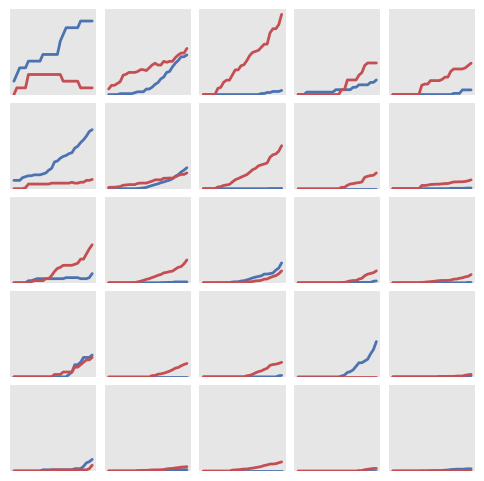

In [25]:


fig = plt.figure(figsize = (6,6))
gs = gridspec.GridSpec(nc,nc)
gs.update(wspace=0.1, hspace=0.1) # set the spacing between axes. 

fontProperties = {'family':'sans-serif','sans-serif':['Helvetica'],
    'weight' : 'normal', 'size' : 12}

for ic in fullcnames:
    for jc in fullcnames:
        
        ax = plt.subplot(gs[ic * nc + jc])
  
        ax.plot(np.arange(1990, 2018), pblock_matrix[:,ic,jc], lw=2)
        ax.plot(np.arange(1990, 2018), nblock_matrix[:,ic,jc], lw=2, color=sns.color_palette()[3])
        
        ax.set_ylim([0, 0.8])
        ax.set_yticks([0,0.75])
        
        ax.tick_params(axis='y', which='major', labelsize=10)
        for tick in ax.get_yticklabels():
            tick.set_fontname("Helvetica") #"Comic Sans MS")
        
        for tick in ax.get_xticklabels():
            tick.set_fontname("Helvetica")
            tick.set_rotation(45)

        #if ~(ic == 0 and jc ==2 or ic==2 and jc ==0):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
        ax.set_facecolor('0.9')
        
        if jc > -1:
            ax.set_yticks([])
        
        if ic <6:
            ax.set_xticks([])


plt.show()

# Multinomial Link Prediction

In [4]:
panel_data = pd.read_csv('data/link_prediction_panel_data_1990_2017.csv.gz')


net_panel = panel_data.merge(net_auc.rename(columns={'CitingCountry':'oCountry', 'CitedCountry':'tCountry','CitedYear':'year'}), 
                           how='left', on=['oCountry','tCountry','year'])

net_panel['edge_preference'] = 1 + (net_panel['Zscore'] < 0).astype(int)
net_panel.loc[net_panel['Significant'].isnull(), 'edge_preference'] = 0

net_panel['edge_preference'].unique()

dummy_years=['year_'+str(i) for i in range(syear + 1, eyear + 1)]

all_dummies=['comlang_off','SameContinent']+dummy_years

net_panel_with_dummies = pd.get_dummies(net_panel, columns=['year'], drop_first=True)
net_panel_with_dummies[dummy_years] = net_panel_with_dummies[dummy_years].astype(int)



v1=['oGDP_PCAP','tGDP_PCAP', 'oPop','tPop']
v2=['PhysicalDistance','SameContinent']
v3=['comlang_off','TopicSimilarity']
v4=['cumulative_laws']
v5=['CollabStrength']
v6=['oTopFrac','tTopFrac']

exog_var_sets = [v1+dummy_years,v2,v3,v4,v5]
dep_var = "edge_preference"

Nmodels = len(exog_var_sets)

fit_models = []
for icol in range(Nmodels):
    exog_vars = list(chain.from_iterable(exog_var_sets[:(icol+1)]))
    X = net_panel_with_dummies[exog_vars + [dep_var]].dropna().reset_index(drop=True)

    Y = X[dep_var]
    X = sm.add_constant(X[exog_vars])

    for c in exog_vars:
        if X[c].nunique() > 2:
            X[c] = (X[c] - X[c].mean())/X[c].std()

    model = sm.MNLogit(Y, X).fit()
    fit_models.append(model)
    

Optimization terminated successfully.
         Current function value: 0.035284
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.036045
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.038455
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.038375
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.036143
         Iterations 13


In [7]:
from vizutils import pvalue2stars, table_row, make_multinomial_latex_table

namedict = {'const':'Intercept', 'oTopFrac':'Origin top journal fraction', 'tTopFrac':'Target top journal fraction', 
'oGDP_PCAP':'Log origin GDP per capita', 'oPop':'Log origin population','tPop':'Log target population',
           'tGDP_PCAP':'Log target GDP per capita', 'PhysicalDistance': 'Physical distance', 'TopicSimilarity':'Field similarity', 
            'comlang_off':'Same official language', 'CollabStrength':'Log collaboration strength','SameContinent':'Same continent',
           'cumulative_laws':'Bilateral research agreements'}
years={i: i[-4:] for i in dummy_years}
merged_dict = years.copy()  # Create a copy of dict1 to avoid modifying the original
merged_dict.update(namedict)

make_multinomial_latex_table(fit_models, exog_var_sets, dep_var, namedict, caption_text="")

KeyError: 'year_1991'

## multinomial VIF

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import add_constant


# Add a constant (Intercept) for VIF calculation
X = net_panel_with_dummies[v1+v2+v3+v4+v5+v6+dummy_years].dropna().reset_index(drop=True)# Adds an intercept term
X = sm.add_constant(X)

# Compute VIF for each feature
vif_df = pd.DataFrame()
vif_df["Variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

namedict = {'const':'Intercept', 'oTopFrac':'Origin top journal fraction', 'tTopFrac':'Target top journal fraction', 'oGDP_PCAP':'Log origin GDP per capita', 'oPop':'Log origin population','tPop':'Log target population',
           'tGDP_PCAP':'Log target GDP per capita', 'PhysicalDistance': 'Physical distance', 'TopicSimilarity':'Field similarity', 
            'tradeflow_baci':'Log trade volume', 'comlang_off':'Same official language', 'CollabStrength':'Log collaboration strength','DemocDis': 'Democracy distance','oDemoc':'Origin democracy','tDemoc':'Target democracy','SameContinent':'Same continent',
           'cumulative_laws':'Bilateral research agreements'}

vif_df.replace(namedict,inplace=True)
vif_plot=vif_df[vif_df['Variable']!='Intercept']



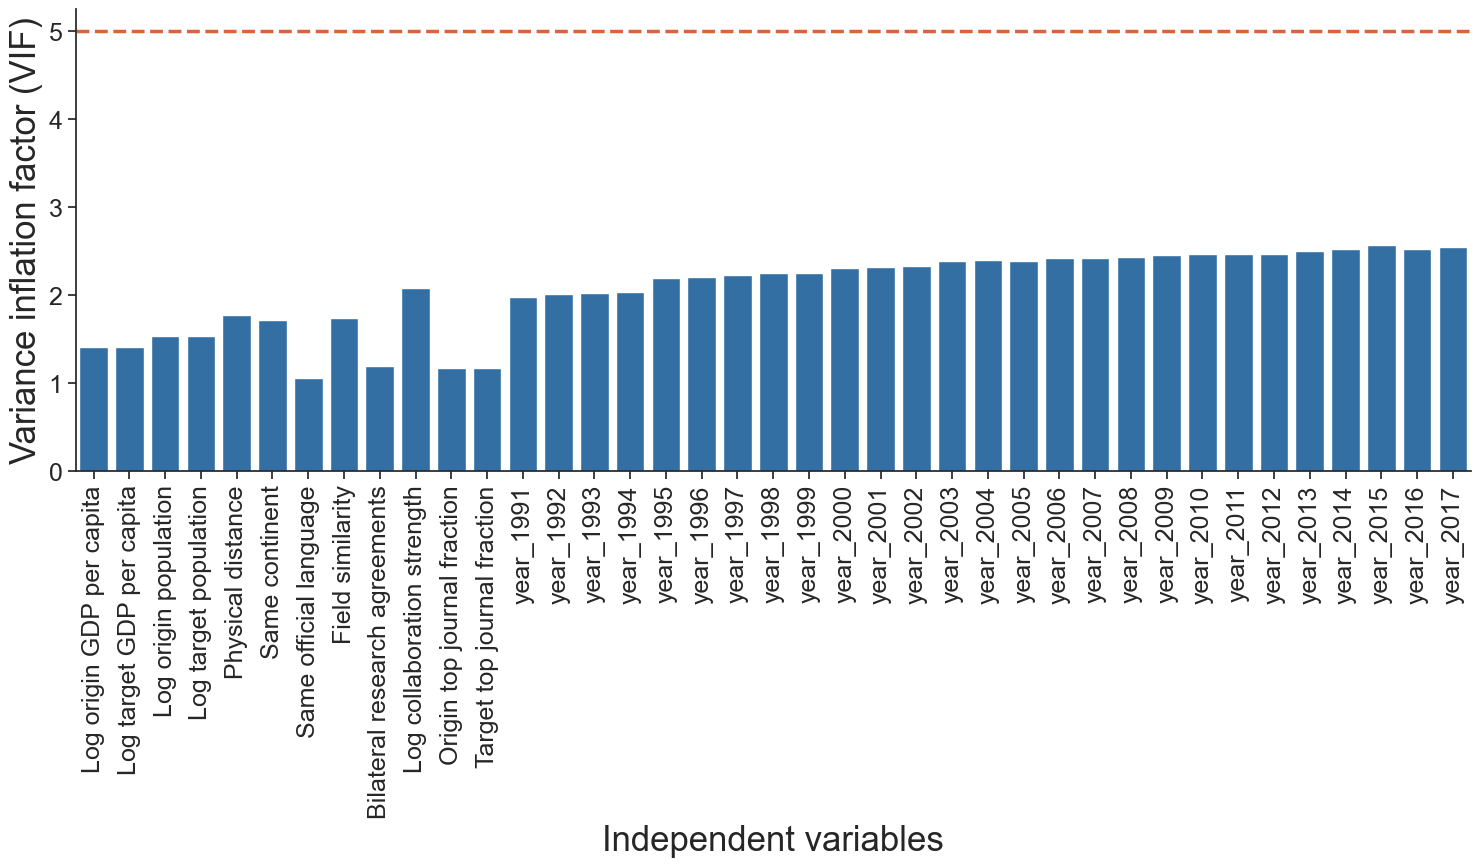

In [14]:
colours=['#8D95A0','#2171b5','#DA6437']

custom_params = {"axes.spines.bottom": True, "axes.spines.right": False, "axes.spines.top": False,
                     "axes.spines.left": True,"ytick.left":True, "xtick.bottom":True}
sns.set_theme(style='ticks', rc=custom_params)


plt.figure(figsize=(18, 6))

ax = sns.barplot(x="Variable", y="VIF", data=vif_plot, 
                     color=colours[1])
    
plt.xlabel("Independent variables", fontsize=25)
plt.ylabel("Variance inflation factor (VIF)", fontsize=25)

plt.xticks(rotation=90, ha='center')

ax.axhline(y=5, color=colours[2],  linestyle='--', lw=2.5)



ax.tick_params(axis='both', which='major', labelsize=18, direction='out',)

plt.show()

In [11]:
def summary_table(model,ycat,ycat_name):
    
    dfpo=model.params.reset_index().rename(columns={'index':'item'})
    dfc1=dfpo[['item',ycat-1]].rename(columns={ycat-1:'risk'})
    
    dfpv=model.pvalues.reset_index().rename(columns={'index':'item'})
    dfpv=dfpv[['item',ycat-1]].rename(columns={ycat-1:'pvalues'})

    df1=dfc1.merge(dfpv,how='left',on='item')
    
    dfcon1=model.conf_int().loc[str(ycat)].reset_index().rename(columns={'index':'item','lower':0,'upper':1})
    df2=df1.merge(dfcon1,how='left',on='item')

    df2['strf']=ycat_name

    return df2

dfc1=summary_table(fit_models[-1],1,'Positive recognition')
dfc2=summary_table(fit_models[-1],2,'Negative recognition')

dfs=pd.concat([dfc1,dfc2])

namedict = {'const':'Intercept', 
            'oTopCumuFrac':'Source top journal fraction', 'tTopCumuFrac':'Target top journal fraction',
            'oPop':'Source population','tPop':'Target population',
             'oGDP_PCAP':'Source GDP per capita', 'tGDP_PCAP':'Target GDP per capita',
            'oTopFrac':'Source top journal fraction', 'tTopFrac':'Target top journal fraction',
            'PhysicalDistance': 'Physical distance', 'tradeflow_baci':'Trade volume', 
            'FieldDistance':'Topic distance', 'SameContinent':'Same continent',
            'CollabStrength':'Collaboration strength',
            'CosineNormStrength':'Normed collaboration strength',
            'comlang_off':'Same official language', 
            'DemocDis': 'Democracy distance','oDemoc':'Source democracy', 'tDemoc':'Target democracy',
           'oGNI_PCAP':'Source GNI per capita', 'tGNI_PCAP':'Target GNI per capita',
           'GNI_PCAP':'GNI per capita', 'GNI':'GNI', 'GDP_PCAP':'GDP per capita',
           'Pop':'Population', 'NumPub':'Number of publications','Agreements':'Bilateral research agreement',
           'RND_per':'Percent of GDP for R&D', "FractionNationalAuthors":"Fraction national authors"}

dfs.replace(namedict,inplace=True)

dfs['category']=dfs['item']

df1 = dfs[dfs["strf"] == "Positive recognition"].reset_index(drop=True)
df2 = dfs[dfs["strf"] == "Negative recognition"].reset_index(drop=True)

df1['xerror']=df1[1]-df1['risk']
df2['xerror']=df2[1]-df2['risk']

df1=df1[df1['item']!='Intercept']
df2=df2[df2['item']!='Intercept']

#dfs

In [25]:
df1

,item,risk,pvalues,0,1,strf,category,xerror
1,Source GNI per capita,-0.092477,6.687006e-01,-0.516027,0.331074,Positive recognition,Source GNI per capita,0.423550
2,Target GNI per capita,-0.569696,3.837964e-03,-0.955899,-0.183493,Positive recognition,Target GNI per capita,0.386203
3,Source population,0.829810,1.235295e-05,0.457744,1.201876,Positive recognition,Source population,0.372066
4,Target population,0.151840,4.359508e-01,-0.230165,0.533844,Positive recognition,Target population,0.382005
5,Physical distance,-0.508793,4.464942e-04,-0.792823,-0.224764,Positive recognition,Physical distance,0.284030
6,Same continent,0.565007,2.512394e-02,0.070523,1.059491,Positive recognition,Same continent,0.494484
7,Topic distance,-1.492858,2.240516e-09,-1.982201,-1.003514,Positive recognition,Topic distance,0.489343
8,Trade volume,-0.450450,2.855107e-02,-0.853653,-0.047247,Positive recognition,Trade volume,0.403203
9,Same official language,1.215920,3.946199e-07,0.746011,1.685828,Positive recognition,Same official language,0.469909
10,Source democracy,-0.429975,9.126712e-04,-0.684106,-0.175844,Positive recognition,Source democracy,0.254131


In [65]:
def wald_mlogit_diff(model, param1, param2=None):
    covar = model.cov_params()
    flipvalue = {'1':'2', '2':'1'}
    if param2 is None:
        param2 = ":".join([flipvalue.get(p, p) for p in param1.split(':')])

    pidx1 = tuple(param1.split(':'))[::-1]
    pidx2 = tuple(param2.split(':'))[::-1]

    diffse = np.sqrt( covar[pidx1][pidx1] + covar[pidx2][pidx2] - 2*covar[pidx1][pidx2] )

    coeffdiff = model.params[int(pidx1[0])-1][pidx1[1]] - model.params[int(pidx2[0])-1][pidx2[1]]
    zscore = coeffdiff/diffse
    pvalue = spstats.norm.sf(np.abs(zscore))*2
    
    return zscore, pvalue

for it in dfc1['item'].values:
    if it != 'const':
        param1 = it+':1'
        print(namedict[it], wald_mlogit_diff(fit_models[-1], param1))


Source GDP per capita (-5.111989857485999, 3.1878294656067625e-07)
Target GDP per capita (-6.8053692331690465, 1.0079039442660139e-11)
Source population (-6.14584782476865, 7.953751154438744e-10)
Target population (-8.527211828903479, 1.4991719615882735e-17)
Physical distance (-0.8668155067897941, 0.38604310430218136)
Same continent (5.880785356364366, 4.083243944465331e-09)
Topic distance (-5.656725877155015, 1.5428788648705385e-08)
Trade volume (-0.6510036661135686, 0.5150441203226309)
Same official language (5.784964801830892, 7.252751471734106e-09)
Source democracy (-2.3998236972873057, 0.016402969952863024)
Target democracy (-2.5031905534685865, 0.012307925775734654)
Democracy distance (-4.554026978359761, 5.262860217362792e-06)
Bilateral research agreement (-4.504142152164928, 6.66415889442e-06)
Collaboration strength (8.443900450036116, 3.069206044102059e-17)
Source top journal fraction (-5.144907044861672, 2.6765330827431096e-07)
Target top journal fraction (8.21067696684086, 2

In [66]:
colours=['#8D95A0','#2171b5','#DA6437']
colours=['#8D95A0','#2171b5',sns.color_palette()[3]]

def logistic_coefficient_plot(df1, df2, ax=None):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,12))
    
    
    df1s=df1[df1['pvalues']<=0.05]
    df1ns=df1[df1['pvalues']>0.05]

    df2s=df2[df2['pvalues']<=0.05]
    df2ns=df2[df2['pvalues']>0.05]

    x1s = df1s['risk']
    y1s = np.array(df1s.index.to_list())-0.2
    xerror1s = df1s['xerror']

    x1ns = df1ns['risk']
    y1ns = np.array(df1ns.index.to_list())-0.2
    xerror1ns = df1ns['xerror']

    x2s = df2s['risk']
    y2s = np.array(df2s.index.to_list())+0.2
    xerror2s = df2s['xerror']

    x2ns = df2ns['risk']
    y2ns = np.array(df2ns.index.to_list())+0.2
    xerror2ns = df2ns['xerror']
    
    y=df1.index.to_list()
    
    ax.errorbar(x1s, y1s, xerr=xerror1s, fmt='o',color=colours[1],label="Positive recognition",ms=4)
    ax.errorbar(x2s, y2s, xerr=xerror2s, fmt='o',color=colours[2],label="Negative recognition",ms=4)
    
    ax.errorbar(x1ns, y1ns, xerr=xerror1ns, fmt='o',color=colours[1],mfc='w',mew=1,label="Positive recognition(not sig)",ms=4)
    ax.errorbar(x2ns, y2ns, xerr=xerror2ns, fmt='o',color=colours[2],mfc='w',mew=1,label="Negative recognition(not sig)",ms=4)

    #ax.errorbar(x1ns, y1ns, xerr=xerror1ns, fmt='o',color=colours[1],label="Positive recognition(not sig)",ms=4, alpha=0.5)
    #ax.errorbar(x2ns, y2ns, xerr=xerror2ns, fmt='o',color=colours[2],label="Negative recognition(not sig)",ms=4, alpha=0.5)

    ax.invert_yaxis()
    
    ax.axvline(x=0, color=colours[0],  linestyle='--',ymin=0,ymax=0.98)

    sns.despine(top=True, right=True, left=True, bottom=False)

    ylabels=df1['item']
    ax.set_yticks(y)
    ax.set_yticklabels(ylabels)
    ax.set_xticks([-3,-2,-1,0,1,2,3,4])
    ax.tick_params(axis="both", which="both", bottom=True, top=False,    
                    labelbottom=True, left=False, right=False, labelleft=True,labelsize=9) 

    ax.set_ylim([len(Model_features)+2.5,0])
    ax.set_xlabel("Regression coefficient",fontsize=10)

    hlines=y
    counter=0
    for ix in hlines: 
        if counter % 2 == 0:
            ax.axhspan(ix - 0.5, ix + 0.5, color=colours[0],alpha=0.3, zorder=0,lw=0)
        counter += 1


    plt.legend(bbox_to_anchor=(-0.3, 0.55, 0.5, 0.5),
        fontsize=10,
               loc="upper left",
               ncol=2,
               markerscale=1,
               frameon=False,
               handletextpad=.1,
               columnspacing=.2)
    
    return ax

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


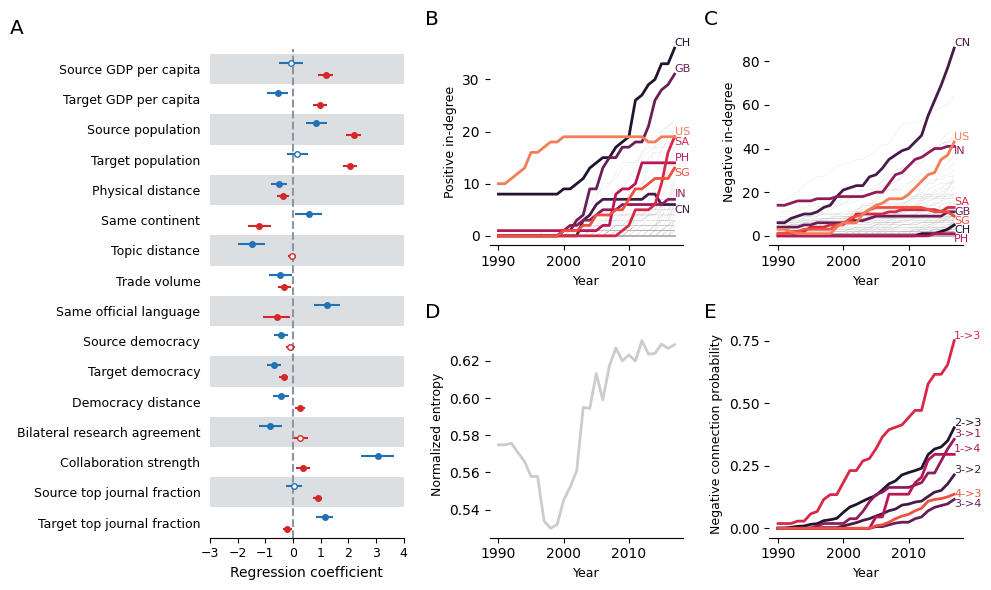

In [73]:
countries2highlight = sorted(['US', 'CH', 'GB', 'PH', 'SA', 'SG', 'CN', 'IN'])

lblsize = 9

layout = [
    ["A", "B", "C"],
    ["A", "D", "E"]
]

fig, axd = plt.subplot_mosaic(layout, figsize=(10,6))

logistic_coefficient_plot(df1, df2, ax=axd["A"])

label = "A"
trans = mtransforms.ScaledTranslation(-2, 7/72, fig.dpi_scale_trans)
axd[label].text(0.0, 1.0, label, transform=axd[label].transAxes + trans,
                   fontsize='x-large', va='center')

comm2color = {0:"#257BA0", 1:"#6AB8AB", 2:"#D65451", 3:"#FFE000", 4:"#FF9400"}

for c in countryprod['Country'].unique():
    countrysub = countryprod[countryprod['Country'] == c].sort_values('Year')
    
    if c in countries2highlight:
        color = sns.color_palette("rocket", n_colors=len(countries2highlight) + 2)[countries2highlight.index(c)]
        axd["B"].plot(countrysub['Year'].values, countrysub['PositiveInDegree'].values, color=color, lw=2, zorder=10)
        axd["C"].plot(countrysub['Year'].values, countrysub['NegativeInDegree'].values, color=color, lw=2, zorder=10)
        
        if c in ['CN', 'SA', 'SG']:
            axd["B"].text(s=c, x=countrysub['Year'].values[-1], y=countrysub['PositiveInDegree'].values[-1],
                    ha='left', va='top', color=color, fontsize=8)
        else:
            axd["B"].text(s=c, x=countrysub['Year'].values[-1], y=countrysub['PositiveInDegree'].values[-1],
                    ha='left', va='bottom', color=color, fontsize=8)
        
        if c in ['IN', 'PH', 'CH', 'SG']:
            axd["C"].text(s=c, x=countrysub['Year'].values[-1], y=countrysub['NegativeInDegree'].values[-1],
                    ha='left', va='top', color=color, fontsize=8)
        elif c in ['GB']:
            axd["C"].text(s=c, x=countrysub['Year'].values[-1], y=countrysub['NegativeInDegree'].values[-1],
                    ha='left', va='center', color=color, fontsize=8)
        else:
            axd["C"].text(s=c, x=countrysub['Year'].values[-1], y=countrysub['NegativeInDegree'].values[-1],
                    ha='left', va='bottom', color=color, fontsize=8)
    else:    
        axd["B"].plot(countrysub['Year'].values, countrysub['PositiveInDegree'].values, color='0.7', lw=0.1, zorder=1)
        axd["C"].plot(countrysub['Year'].values, countrysub['NegativeInDegree'].values, color='0.7', lw=0.1, zorder=1)

axd["B"].set_ylabel('Positive in-degree', fontsize=lblsize)
axd["C"].set_ylabel('Negative in-degree', fontsize=lblsize)
axd["D"].set_ylabel('Normalized entropy', fontsize=lblsize)
axd["E"].set_ylabel('Negative connection probability', fontsize=lblsize)

#axd["E"].axis('off')

axd['D'].plot(np.arange(1990, 2018), ygini, color='0.8', lw=2)

for i,(ic,jc) in enumerate([(1,2), (2,1), (2,3),  (2,0),(0,3), (0,2), (3,2)]):
    color=sns.color_palette("rocket", n_colors=len(countries2highlight) + 2)[i]
    axd["E"].plot(np.arange(1990, 2018), nblock_matrix[:,ic,jc], lw=2, color=color)
    
    if (ic,jc) in [(3,0),  (2,3)]:
        va = 'top'
    elif (ic,jc) in [(3,2), (3,0)]:
        va = 'center'
    else:
        va = 'bottom'
    axd["E"].text(s=str(ic+1)+"->"+str(jc+1), x=2017, y=nblock_matrix[-1,ic,jc], ha='left', va=va, 
                  color=color, fontsize=8)

#axd["E"].set_yticks([0, 0.25, 0.5,0.75])
axd["E"].set_yticks([0, 0.25, 0.5,0.75])


for label in ['B', "C", "D", "E"]:
    axd[label].set_xlabel('Year', fontsize=lblsize)
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(-0.65, 7/72, fig.dpi_scale_trans)
    axd[label].text(0.0, 1.0, label, transform=axd[label].transAxes + trans,
                   fontsize='x-large', va='bottom')#, xx-small, x-small, small, medium, large, x-large, xx-large, larger, smaller
plt.tight_layout()

plt.savefig('Figures/Fig2_networkfeatures.pdf')

plt.show()

In [25]:
def line_stick_auc(ax, auc_data, countries_to_highlight):
    ax.axhline(y=0.6, ls='-', color='0.8', lw=0.5, zorder=1)
    #ax.axhline(y=0.55, ls='-', color='0.8', lw=0.5, zorder=1)
    #ax.axhline(y=0.65, ls='-', color='0.8', lw=0.5, zorder=1)
    ax.axhline(y=0.7, ls='-', color='0.8', lw=0.5, zorder=1)
    ax.axhline(y=0.8, ls='-', color='0.8', lw=0.5, zorder=1)
    
    auc_data = auc_data.sort_values(by='AUC')
    
    for i, (auc, cname) in enumerate(auc_data[['AUC', 'Country']].values):
        if cname in countries_to_highlight:
            ax.plot([i,i], [0.5,auc], color = 'k')
            ax.scatter(i,auc, color='k')
        else:
            ax.plot([i,i], [0.5,auc], color = '0.6')
            ax.scatter(i,auc, color='0.6')
    
    ax.set_xlim([-0.5, auc_data['Country'].nunique()])
    
    ax.set_xticks(np.arange(auc_data['Country'].nunique()))
    ax.set_xticklabels(auc_data['Country'].values, 
                       rotation=45, ha='center', color='0.6', fontsize=8)
    for i in np.where(pyscisci.isin_sorted(auc_data['Country'].values, np.sort(countries_to_highlight)))[0]:
        ax.get_xticklabels()[i].set_color("k")

    ax.set_ylim([0.5, 0.82])
    
    ax.set_yticks([0.5, 0.6, 0.7, 0.8])
    ax.tick_params(axis='y', size=0)
    #ax.set_ylabel('Over-representation')
    for s in ['top', 'right', 'left']:
        ax.spines[s].set_visible(False)
    
    return ax

def mycoefplot(ax, sumdf, fontsize=10, ms=50):
    exog_vars = sumdf.index
    i=len(exog_vars) -1
    for f in exog_vars:
        if f in exog_vars:
            coeff, stderr, pvalue, lower, upper = sumdf.loc[f][['Parameter', 'Std. Err.','P-value', 'Lower CI', 'Upper CI']]
            
            #color = sns.color_palette()[1]
            color = sns.color_palette("rocket", n_colors = 4)[1]
            if pvalue >= 0.05:
                fc = 'w'
            else:
                fc = color

            ax.plot([lower, upper], [i]*2, color=color, lw=2, zorder=5)
            ax.scatter(coeff, i, s=ms, color=fc, edgecolors = color, zorder=10)
            
            if False:
                ax.text(1.9, i, "(S.E.={},P={})".format(np.round(stderr, 2), np.round(pvalue, 2)), fontsize=14, va='center')
            i-=1

    ax.grid(axis='x')
    ax.axvline(x=0, lw=2, color='k')
    ax.set_xlim([-2.5, 1.5])
    ax.set_xticks([-2,-1,0,1])
    ax.set_xlabel('Model coefficient', fontsize=fontsize)
    ax.set_ylim([-1, len(exog_vars)])

    ax.set_yticks(list(range(len(exog_vars))))

    if True:
        ax.set_yticklabels([namedict.get(fname, fname) for fname in exog_vars[::-1]], 
                             fontdict = {'rotation':0, 'horizontalalignment':'right',
                                        'fontsize':fontsize})    

    ax.tick_params(axis='x', which='major', labelsize=fontsize)
    
    return ax

In [75]:

def pvalue2stars(pvalue):
    if pvalue < 0.01:
        return "^{***}"
    elif pvalue < 0.05:
        return "^{**}"
    elif pvalue < 0.1:
        return "^{*}"
    else:
        return ""
    
def table_row(varname='const', offset=0, roun=2, modellist=[], namedict={}):
    row_text = namedict[varname] + " & "*(offset+1) + " & ".join([ "$" + str(model.params[varname].round(roun)) + pvalue2stars(model.pvalues[varname]) + "$" for model in modellist[offset:]]) + "\\\\ \n"
    row_text +=  " & "*(offset+1) + " & ".join([ "$(" + str(model.conf_int().loc[varname]['lower'].round(roun)) + "," + str(model.conf_int().loc[varname]['upper'].round(roun)) + ")$" for model in modellist[offset:]]) + "\\\\ \n"
    row_text +=  " & "*(offset+1) + " & ".join([ "S.E. $" + str(model.std_errors[varname].round(roun)) + "$ p=$" + str(model.pvalues[varname].round(4)) + "$" for model in modellist[offset:]]) + "\\\\ [0.8ex]  \n"
    return row_text

def make_latex_table(data, effect_vars = [], exog_var_sets = [], dep_var = "", use_const = False, 
                     normvar = True, namedict = {}, caption_text=""):
    
    Nmodels = len(exog_var_sets)
    
    fit_models = []
    for icol in range(Nmodels):
        exog_vars = list(chain.from_iterable(exog_var_sets[:(icol+1)]))
        self_panel = data[effect_vars + exog_vars + [dep_var]].dropna().reset_index(drop=True)
        if normvar:
            for c in exog_vars + [dep_var]:
                self_panel[c] = (self_panel[c] - self_panel[c].mean())/self_panel[c].std()
                
        self_panel=self_panel.set_index(effect_vars)
        if use_const:
            exog = sm.add_constant(self_panel[exog_vars])
        else:
            exog = self_panel[exog_vars]
        mod = PanelOLS(self_panel[dep_var], self_panel[exog_vars], entity_effects=True, time_effects=True)
        fit_models.append(mod.fit(cov_type='clustered', cluster_entity=True))
    
    
    table_text = """\\begin{table}[!htb] \\centering 
    \\small
  \\caption{\\textbf{National self-preference.}
  Model coefficients labeled by $p$-value. Standard errors in parentheses.}  
  \\label{table:} 
  \\begin{tabular}{l""" + "l"*Nmodels + "}"
    
    table_text += """\\\\[-1.8ex]\\hline 
\\hline \\\\[-1.8ex] 
\\multicolumn{""" + str(Nmodels+1) + """}{c}{\\textbf{Dependent variable: Fraction of publications in top venues.}} \\\\[0.8ex]\\hline 
 & \\multicolumn{""" + str(Nmodels) + """}{c}{Model}  \\\\ """
    
    table_text += "\cline{2-" + str(Nmodels + 1) + "} \\\\[-1.8ex] "
    
    for icol in range(Nmodels):
        table_text += "& (" + str(icol + 1) + ")"
    
    table_text += " \\\\ \hline \\\\[-1.8ex] \n"
    
    # add constant
    if use_const:
        table_text += table_row(varname='const', offset=0, roun=2, modellist=fit_models, namedict=namedict)
    
    for offset, varlist in enumerate(exog_var_sets):
        for var in varlist:
            table_text += table_row(varname=var, offset=offset, roun=2, modellist=fit_models, namedict=namedict)
    
    table_text += """\\hline 
\\hline \\\\[-1.8ex] 
\\textit{Note:} & \\multicolumn{2}{r}{$^{*}p<0.05$; $^{**}p<0.01$; $^{***}p<0.001$} \\\\ \n"""
    
    table_text += "Observations & " + " & ".join([str(model.nobs) for model in fit_models]) + " \\\\ \n"
    table_text += "$R^2$ & " + " & ".join([str(np.round(model.rsquared, 4)) for model in fit_models]) + " \\\\ \n"
    table_text += "Log Likelihood & " + " & ".join([str(model.loglik.round(2)) for model in fit_models]) + " \\\\ \n"
    table_text += "F statistic & " + " & ".join(["$" + str(np.round(model.f_statistic.stat, 2)) + pvalue2stars(model.f_statistic.pval) + "$ (d.f.=" + str(model.f_statistic.df) + ")" for model in fit_models]) + " \\\\ \n"
    table_text += "\\hline \n\\end{tabular} \n\\end{table}"
    
    print(table_text)
    return table_text
    


# Weighted Logistic Regression Model for Idea Diffusion

In [128]:
panel_data = pd.read_csv('data/diffusion_panel_data_1990_2017.csv.gz')



network_features = [ 'Pedge', 'Nedge'] 
#network_features = [ 'Pedge', 'Nedge', 'SameComm'] 
#network_features = [ 'Pedge', 'Nedge',  'pr_o', 'pr_d'] 
network_features = [ 'Pedge', 'Nedge', 'SameComm', 'pr_o', 'pr_d'] 

Model_features = [
#'Pop_o','Pop_d', 
'GDP_PCAP_o','GDP_PCAP_d',
'NumPub_o','NumPub_d', 
'NormNcites',  
'FieldDistance', 
'dist', 
'comlang_off'
] + network_features


X = panel_data[Model_features + [ 'Norigin', 'Fideas']].dropna().copy()
Y = X['Fideas']
freq_weights = X['Norigin'].values
X = sm.add_constant(X[Model_features])

for c in Model_features:
    if X[c].nunique() > 2:
        X[c] = (X[c] - X[c].mean())/X[c].std()

vif_df = pd.DataFrame()
vif_df["Variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_df['Variable']=vif_df['Variable'].replace(namedict)

#model=sm.GLM(Y, X, family=sm.families.Binomial(sm.families.links.logit())).fit()
model=sm.GLM(Y, X, family=sm.families.Binomial(sm.families.links.logit()), freq_weights=freq_weights).fit()

predictions = model.predict(X) 
print(model.pseudo_rsquared(kind='mcf'))
params = model.params
conf = model.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
print(np.exp(conf))

model.summary()